In [1]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')


search for a bird:

In [3]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://www.almanac.com/sites/default/files/image_nodes/bluebird-3456115_1920.jpg'

download a URL:

In [4]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)


Path('bird.jpg')

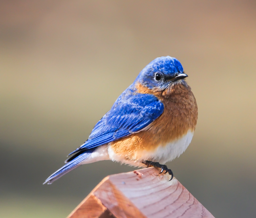

In [5]:
from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)


let us do the same with forest phtotos:

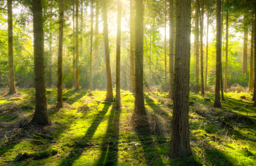

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

grab 200 samples:

In [7]:
searches = 'bird','horse','dolphin','panda','tiger','lion','dog','cat','koala','kangaroo'
path = Path('bird_or_not')
from time import sleep

In [8]:
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} zoo photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} wild photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/home/vscode/.local/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home/vscode/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)


102

train a model:

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

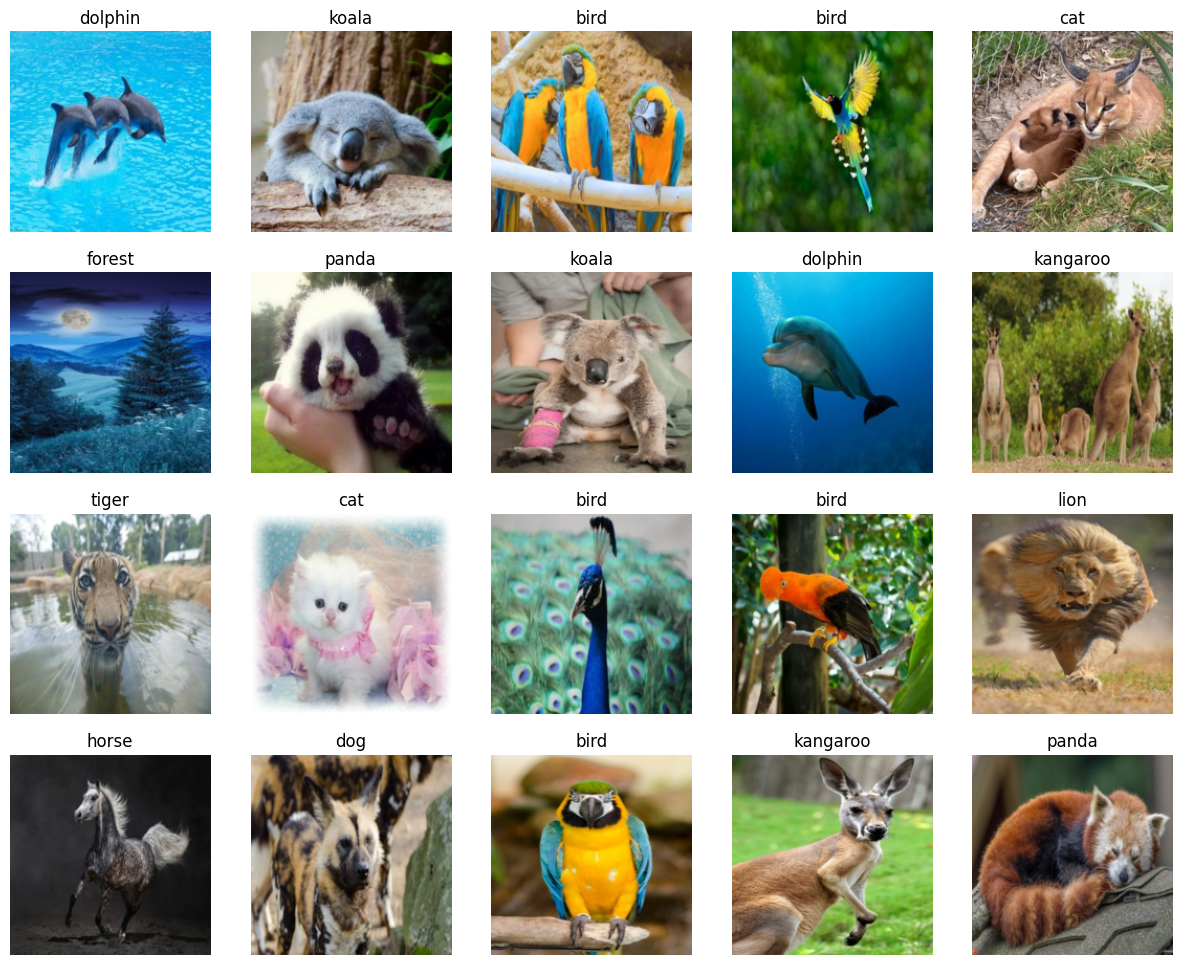

In [11]:
dls.show_batch(max_n=20)

use fine-tune to train our model:

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Create a confusion matrix:

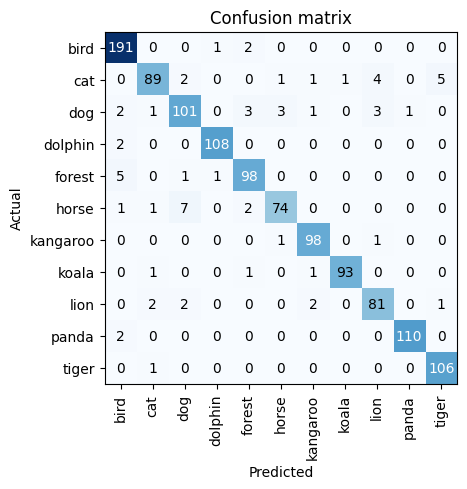

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


show the image with highest loss:

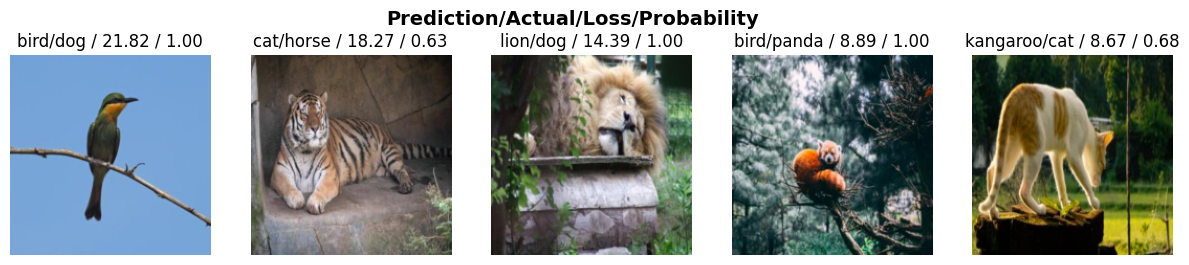

In [14]:
interp.plot_top_losses(5, nrows=1)

Use our model:

In [15]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
